# 2-5 補足
ここでは、これまでの解説で登場した 「トークン化」「位置符号化 (Positional Encoding)」「線形層 (Linear)」「Softmax関数」 について、個別に詳しく解説します。

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# 図のスタイル設定
sns.set(style="whitegrid")

## 1. トークン化 (Tokenization)
コンピュータは「文字」を直接理解できないため、計算を行うためには文章を数値（ID）に変換する必要があります。この過程がトークン化です。

### 手順
1. 分割: 文章を単語や部分単語（Subword）単位に区切る。

2. ID化: 辞書（Vocabulary）を使って、各トークンを一意のID番号に変換する。

ここでは、簡易的な辞書を使って仕組みを確認します。

In [7]:
# 簡易的な辞書の作成
vocab = {
    "I": 0, "love": 1, "machine": 2, "learning": 3, ".": 4,
    "<PAD>": 5  # パディング用（長さを揃えるため）
}

text = "I love machine learning ."

# 1. 空白で分割（英語の場合の簡易的な手法）
tokens = text.split()
print(f"Tokens: {tokens}")

# 2. IDに変換
input_ids = [vocab[token] for token in tokens]
print(f"Input IDs: {input_ids}")

# Tensor化（バッチ次元を追加: [Batch_Size, Seq_Len]）
input_tensor = torch.tensor([input_ids])
print(f"Tensor Shape: {input_tensor.shape}")

Tokens: ['I', 'love', 'machine', 'learning', '.']
Input IDs: [0, 1, 2, 3, 4]
Tensor Shape: torch.Size([1, 5])


## 2. 位置符号化
 (Positional Encoding)Transformerはデータを並列（一括）で処理するため、そのままでは「単語の順番」という情報を失ってしまうため、「犬が人を噛んだ」と「人が犬を噛んだ」を区別するために、各単語ベクトルに位置情報を加算します。

 「Attention Is All You Need」では、以下の正弦波（sin）と余弦波（cos）を用いた数式が提案されています。

 $$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

 $$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

 $pos$: 文中の位置（0番目, 1番目...）<br>
 $i$: ベクトルの次元のインデックス<br>
 $d_{model}$: 埋め込みベクトルの次元数この波のパターンを加えることで、モデルは相対的な位置関係を学習しやすくなります。

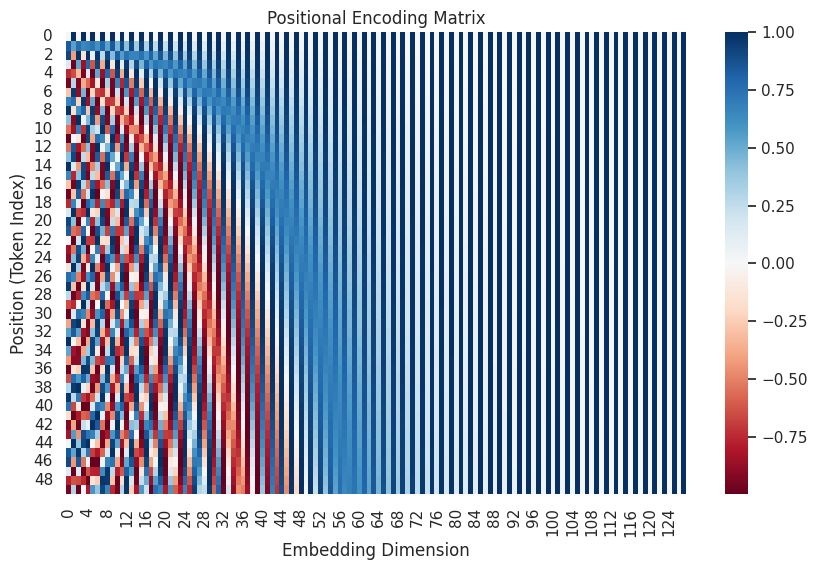

In [8]:
def get_positional_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

    # 偶数インデックスにはsin
    pe[:, 0::2] = torch.sin(position * div_term)
    # 奇数インデックスにはcos
    pe[:, 1::2] = torch.cos(position * div_term)

    return pe

# 設定: 長さ50、次元数128
seq_len = 50
d_model = 128
pe = get_positional_encoding(seq_len, d_model)

# 可視化
plt.figure(figsize=(10, 6))
sns.heatmap(pe, cmap="RdBu", center=0)
plt.title("Positional Encoding Matrix")
plt.xlabel("Embedding Dimension")
plt.ylabel("Position (Token Index)")
plt.show()

## 3. 線形層 (Linear Layer)
Transformer内部の Feed-Forward Networks や、Query, Key, Valueを作成する際に多用されるのが線形層（全結合層）です。

数式入力 $x$ に対して、重み行列 $W$ を掛け、バイアス $b$ を足します。

$$y = xW^T + b$$

これは、ベクトルを「別の空間に写像（変換）」する役割を持ちます。<br>
例えば、Queryを作る際は「検索に適した形」にベクトルを変形させています。

In [9]:
# 入力: [バッチサイズ1, 系列長5, 次元数4]
input_vector = torch.randn(1, 5, 4)

# 線形層の定義: 4次元 -> 8次元 に拡張
linear_layer = nn.Linear(in_features=4, out_features=8)

# 計算
output_vector = linear_layer(input_vector)

print(f"Input shape : {input_vector.shape}")
print(f"Output shape: {output_vector.shape}")
print("\n重み(Weight)の一部:\n", linear_layer.weight.detach().numpy()[0])

Input shape : torch.Size([1, 5, 4])
Output shape: torch.Size([1, 5, 8])

重み(Weight)の一部:
 [-0.20856065  0.4616735  -0.19643116  0.23035854]


## 4. Softmax関数
Attentionスコアを確率（重み）に変換するために使われます。入力された数値群を、「合計すると1.0（100%）になる確率分布」 に正規化します。特徴大きな値はより強調され（確率が高くなり）、小さな値は抑制されます。これにより、モデルは「どの単語に注目すべきか」をはっきりと決定できます。

$$\text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$$

Scores: [2.  1.  0.1 5. ]
Probs : [0.0462899  0.0170291  0.00692352 0.92975754]
Sum   : 1.0


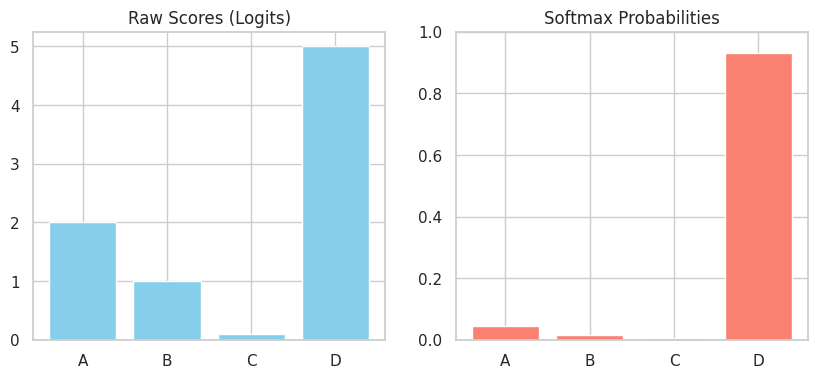

In [10]:
# 適当なスコア（logits）
scores = torch.tensor([2.0, 1.0, 0.1, 5.0])

# Softmax計算
probs = F.softmax(scores, dim=0)

print("Scores:", scores.numpy())
print("Probs :", probs.numpy())
print("Sum   :", probs.sum().item()) # 合計は必ず1になる

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 生のスコア
axes[0].bar(["A", "B", "C", "D"], scores.numpy(), color='skyblue')
axes[0].set_title("Raw Scores (Logits)")

# Softmax後の確率
axes[1].bar(["A", "B", "C", "D"], probs.numpy(), color='salmon')
axes[1].set_title("Softmax Probabilities")
axes[1].set_ylim(0, 1)

plt.show()

### 図の解説
左の棒グラフ（スコア）では 5.0 と 2.0 の差は数値通りですが、右の棒グラフ（確率）を見ると、5.0 だった "D" が大部分の確率（ほぼ1.0に近い）を占めています。 このようにSoftmaxは、最も重要な要素にAttentionを向ける 効果があります。